In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
import torch.nn.functional as F
from collections import deque
import time

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from maddpg_agents import Maddpg
from hyperparameters import *

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [5]:
def maddpg():
    
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    maddpg = Maddpg(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=SEED)

    scores_deque = deque(maxlen=100)
    all_scores = []
    all_avg_score = []
    
    noise = NOISE
    
    for i_episode in range(NB_EPISODES+1):  
             
        env_info = env.reset(train_mode=True)[brain_name]          # reset the environment  
        maddpg.reset()                                             # reset the agents 
            
        states = env_info.vector_observations                      # get the current state for each agent 
        episode_scores = np.zeros(num_agents)                              # initialize the score (for each agent)

        for steps in range(NB_STEPS):            
            actions = maddpg.act(states, noise)                    # retrieve actions to performe for each agents 
            noise *= NOISE_REDUCTION                               # Decrease action noise
            env_info = env.step(actions)[brain_name]               # send all actions to tne environment
            next_states = env_info.vector_observations             # get next state for each agent
            rewards = env_info.rewards                             # get reward (for each agent)
            dones = env_info.local_done                            # see if episode finished
            
            maddpg.step(states, actions, rewards, next_states, dones, i_episode)  
            episode_scores += np.array(rewards)                    # update the score (for each agent)
            states = next_states                                   # roll over states to next time step
            if np.any(dones):                                      # exit loop if episode finished
                break
        
        episode_score  = np.max(episode_scores)  # Consider the maximum score amongs all Agents
        all_scores.append(episode_score)
        scores_deque.append(episode_score)
        avg_score = np.mean(scores_deque)

        print('\rEpisode {}\tAverage Score: {:.2f}\tCurrent score: {:.2f}'.format(i_episode, avg_score, episode_score), end="")
        if i_episode>0 and i_episode % 100 == 0:
            print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, avg_score, episode_score))
            maddpg.checkpoints(solution = 'maddpg')
            all_avg_score.append(avg_score)
        
        if (i_episode > 99) and (avg_score >=0.5):
            print('\rEnvironment solved in {} episodes with an Average Score of {:.2f}'.format(i_episode, avg_score))
            maddpg.checkpoints(solution = 'maddpg')
            break
        
    np.save('output/maddpg_scores.npy', all_scores)
    return all_scores

In [6]:
scores = maddpg()

Episode: 100	Average Score: 0.00	Current Score: 0.00
Episode: 200	Average Score: 0.01	Current Score: 0.00
Episode: 300	Average Score: 0.02	Current Score: 0.00
Episode: 400	Average Score: 0.02	Current Score: 0.00
Episode: 500	Average Score: 0.01	Current Score: 0.00
Episode: 600	Average Score: 0.02	Current Score: 0.00
Episode: 700	Average Score: 0.04	Current Score: 0.10
Episode: 800	Average Score: 0.04	Current Score: 0.00
Episode: 900	Average Score: 0.06	Current Score: 0.10
Episode: 1000	Average Score: 0.09	Current Score: 0.00
Episode: 1100	Average Score: 0.10	Current Score: 0.30
Episode: 1200	Average Score: 0.10	Current Score: 0.10
Episode: 1300	Average Score: 0.08	Current Score: 0.10
Episode: 1400	Average Score: 0.11	Current Score: 0.19
Episode: 1500	Average Score: 0.14	Current Score: 0.20
Episode: 1600	Average Score: 0.16	Current Score: 0.20
Episode: 1700	Average Score: 0.15	Current Score: 0.10
Episode: 1800	Average Score: 0.19	Current Score: 0.10
Episode: 1900	Average Score: 0.31	Cur

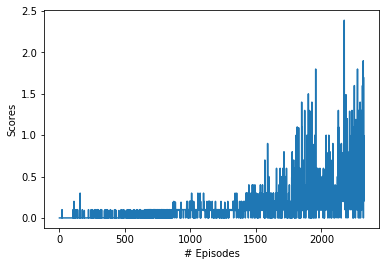

In [7]:
f = plt.figure()
ax = f.add_subplot(111)
plt.plot(range(1, len(scores) + 1), scores)
plt.xlabel('# Episodes')
plt.ylabel('Scores')
plt.savefig('output/maddpg_scores_plot.png')
plt.show()

In [8]:
env.close()